<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2019


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> SearchLight </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> November 25, 2019 </b></p>

<hr style='height:5px;border:none' />

# 1. Motivation
<hr style="height:1px;border:none" />

In the previous class, we saw that patterns from multiple voxels in fMRI data allow us to classify the stimulus type. We examined the case where we know the ROI (region of interest) to focus on, as well as the case, we don't know which voxel features are useful thus selecting potentially useful features. 

The goal in the **searchlight** method is to look for a neighborhood around a voxel where voxel features can accurately classify possible outcomes. To demonstrate this idea, let's take a look at the Haxby data again.


## Data
As we saw in the previous class, the Haxby data set was acquired while subjects viewed pictures of different types in multiple runs of fMRI acquisition. For this example, we will focus on the default subject (subject 02).

[`<LocalDataPlot.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/SearchLight/LocalDataPlot.py)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA
from nilearn.image import new_img_like, load_img



##### PARAMETERS
TR = 2.5

##### DIRECTORY BUSINESS ######
# original data directory where haxby2001 directory resides
dataDir = '/tmp/Data'


##### DATA FILES
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir=dataDir)
imgfMRI = haxby_dataset.func[0]   # fMRI data file
imgAnat = haxby_dataset.anat[0]   # structural data file
imgMask = haxby_dataset.mask   # ventral-temporal streaming mask
tableTarget = haxby_dataset.session_target[0]  # session target table file

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Informative neighborhood

Say, you want to take a look at the neighborhood of voxel (27, 23, 30). So let's create a 3D array of a mask, with a cube of 5 x 5 x 5 voxels centered at this particular voxel. 

In [2]:
###### NEIGHBORHOOD AROUND A VOXEL (WITHIN VT AREA)
voxX = 27
voxY = 23
voxZ = 30
boxWidth = 5
boxHalfWidth = np.floor(boxWidth/2).astype(int)  # half box width

# loading mask image
imgMask = load_img(haxby_dataset.mask)   # mask image object
X_mask = imgMask.get_data().astype(np.int)   # mask image array

# zero-ing voxels outside the box
X_mask[:(voxX-boxHalfWidth),:,:] = 0
X_mask[(voxX+boxHalfWidth+1):,:,:] = 0
X_mask[:,:(voxY-boxHalfWidth),:] = 0
X_mask[:,(voxY+boxHalfWidth+1):,:] = 0
X_mask[:,:,:(voxZ-boxHalfWidth)] = 0
X_mask[:,:,(voxZ+boxHalfWidth+1):] = 0

# creating a new image object for the box
imgBox = new_img_like(imgMask, X_mask)


Just FYI, this is where the neighborhood is located, somewhere in the ventral temporal area.

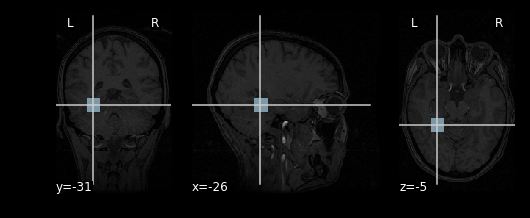

In [3]:
# Visualizing the mask, in relation to the anatomical
plot_roi(imgBox, bg_img=imgAnat, cmap='Paired')

Now we shall extract voxel time series data from this neighborhood.

In [4]:
# Masking the image data with mask, extracting voxels
masker = NiftiMasker(mask_img=imgBox,
                     standardize=True,
                     detrend=True,
                     high_pass=0.008, t_r=TR)
# Extracting the voxel time series within the mask
X_fMRI = masker.fit_transform(imgfMRI)

In [5]:
X_fMRI.shape

(1452, 125)

There are 125 voxels (or features) in this neighborhood.

Now, let's load the behavior data associated with this experiment. We are creating a numeric label **`labelInd`** in the task information dataframe.

In [6]:
###### LOADING BEHAVIORAL DATA
# loading the behavior data into a dataframe
targetData = pd.read_csv(tableTarget, sep=' ')
# stimulus types
targetNames = sorted(targetData.labels.unique())
# Creating numerical labels
targetData['labelInd'] = 0
for i,iCat in enumerate(targetNames):
    targetData.loc[targetData.labels==iCat, 'labelInd'] = i

For the sake of simplicity (and ease of computation), we will focus on `'face'` and `'house'` conditions only. We mask our extracted fMRI data (within the cube) as well as the behavior data for these two conditions only.

In [7]:
###### MASKING FOR SELECTED STIMS
targetNames = ['face', 'house']  # the stims of interest
stimMask = targetData.labels.isin(targetNames)  # indices for the stim of interest
X_fMRI_selected = X_fMRI[stimMask]   # features (for selected stimuli only)
y = np.array(targetData.labelInd)[stimMask]  # labels

Just as a demonstration, we plot the extracted fMRI data (projected to 2D space by a PCA), with faces and houses denoted in different colors.

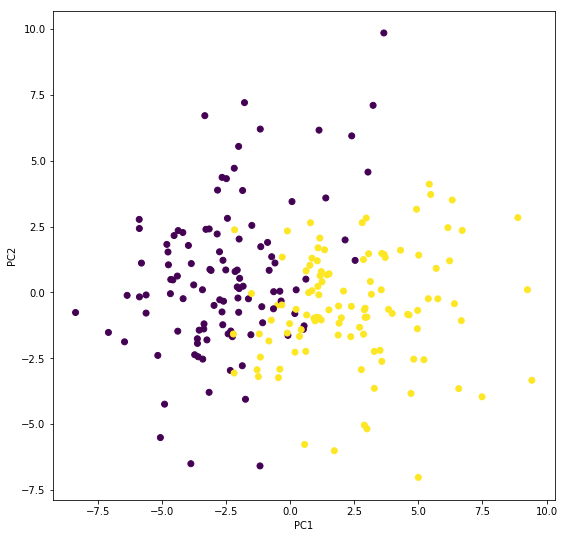

In [8]:
##### PLOTTING DIMENSION REDUCED DATA
# PCA with largest 2 PCs
fMRIpca = PCA(n_components=2)
PC = fMRIpca.fit_transform(X_fMRI_selected)


# plotting the low dimension data (bottle, scissors and face only)
plt.figure(figsize=[9,9])
plt.scatter(PC[:,0], PC[:,1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Although there is some overlap, the two groups are separated into their own groups. If we are to use information from these voxels (features) to train a classifier, we should be able to generate a fairly accurate classifier.

## Non-informative neighborhood

Now, let's focus on another neighborhood, which is not located in the VT area. In particular, this is where the neighborhood is located. 

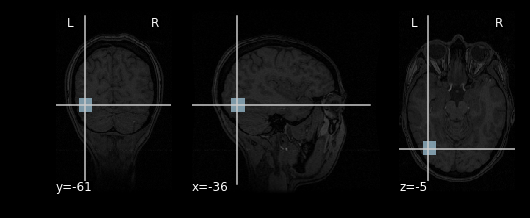

In [9]:
###### NEIGHBORHOOD AROUND A VOXEL (OUTSIDE VT AREA)
voxX = 30
voxY = 15
voxZ = 30

# loading mask image
imgMask = load_img(haxby_dataset.mask)   # mask image object
X_mask = imgMask.get_data().astype(np.int)   # mask image array

# zero-ing voxels outside the box
X_mask[:(voxX-boxHalfWidth),:,:] = 0
X_mask[(voxX+boxHalfWidth+1):,:,:] = 0
X_mask[:,:(voxY-boxHalfWidth),:] = 0
X_mask[:,(voxY+boxHalfWidth+1):,:] = 0
X_mask[:,:,:(voxZ-boxHalfWidth)] = 0
X_mask[:,:,(voxZ+boxHalfWidth+1):] = 0

# creating a new image object for the box
imgBox = new_img_like(imgMask, X_mask)

# Visualizing the mask, in relation to the anatomical
plot_roi(imgBox, bg_img=imgAnat, cmap='Paired')

Now let's plot the features in this neighborhood (projected to a 2D space).

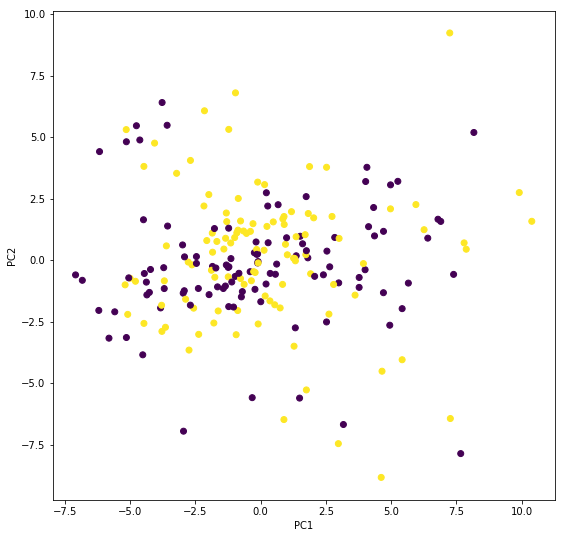

In [10]:
###### LOADING AND MASKING IMAGE DATA

# Masking the image data with mask, extracting voxels
masker = NiftiMasker(mask_img=imgBox,
                     standardize=True,
                     detrend=True,
                     high_pass=0.008, t_r=TR)
# Extracting the voxel time series within the mask
X_fMRI = masker.fit_transform(imgfMRI)
# masking for selected stims
X_fMRI_selected = X_fMRI[stimMask]   # features (for selected stimuli only)




##### PLOTTING DIMENSION REDUCED DATA
# PCA with largest 2 PCs
fMRIpca = PCA(n_components=2)
PC = fMRIpca.fit_transform(X_fMRI_selected)


# plotting the low dimension data (bottle, scissors and face only)
plt.figure(figsize=[9,9])
plt.scatter(PC[:,0], PC[:,1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

As you can see, two groups are not quite separable. 

# 2. Searchlight
<hr style="height:1px;border:none" />

The main idea of **searchlight** is to examine the neighborhood (a sphere) around each voxel, for all voxels in the brain. At each neighborhood, a classifier is trained and examined with a cross-validation, and the resulting accuracy is returned as how informative that voxel (and the surrounding neighborhood) is for classifying the outcome. The idea is somewhat similar to the feature selection with ANOVA, but in this case the feature selection is done by actual classifiers. As you can imagine, this can be somewhat computationally intensive. 

There is a tool, **`SearchLight`**, under **`nilearn.decoding`**, that implements all the necessary steps of searchlight, and returns the accuracy score to quantify how informative the voxel is. Now let's examine the searchlight method based on the same data set.

[`<SearchLightFaceHouseSVM.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/SearchLight/SearchLightFaceHouseSVM.py)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_img
from nilearn.input_data import NiftiMasker
from nilearn.image import new_img_like, load_img, index_img, mean_img
from nilearn.decoding import SearchLight
from sklearn.model_selection import KFold



##### PARAMETERS
TR = 2.5

##### DIRECTORY BUSINESS ######
# original data directory where haxby2001 directory resides
dataDir = '/tmp/Data'


##### DATA FILES
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir=dataDir)
imgfMRI = haxby_dataset.func[0]   # fMRI data file
imgAnat = haxby_dataset.anat[0]   # structural data file
imgMask = haxby_dataset.mask   # brain mask
tableTarget = haxby_dataset.session_target[0]  # session target table file


Now, we detrend and standardize the fMRI data, and keep the resulting data as an image object.

In [12]:
##### DETRENDING AND STANDARDIZING FMRI DATA
# Masking the image data with mask, extracting voxels
detrend = NiftiMasker(mask_img=imgMask,
                     standardize=True,
                     detrend=True,
                     high_pass=0.008, t_r=TR)
# Extracting the voxel time series within the mask
X_fMRI_detrend = detrend.fit_transform(imgfMRI)
# Transforming back to the original space to get an image object
imgfMRIDetrend = detrend.inverse_transform(X_fMRI_detrend)

Ideally, we have a super-fast computer that can calculate anything instantaneously. However, as mentioned before, searchlight is a quite computationally intensive task. So we focus on a small block of the brain covering the left VT area.

In [13]:
###### AREA TO FOCUS ON
voxXmin = 21
voxXmax = 34
voxYmin = 16
voxYmax = 26
voxZmin = 27
voxZmax = 32

# loading mask image
imgMask = load_img(haxby_dataset.mask)   # mask image object
X_mask = imgMask.get_data().astype(np.int)   # mask image array
X_box = np.zeros_like(X_mask)  # zero array, same size as X_mask

# Voxels within the box are turned to one
X_box[voxXmin:(voxXmax+1), voxYmin:(voxYmax+1), voxZmin:(voxZmax+1)] = 1

# creating a new image object for the box
imgBox = new_img_like(imgMask, X_box)

This is the area we focus on. 

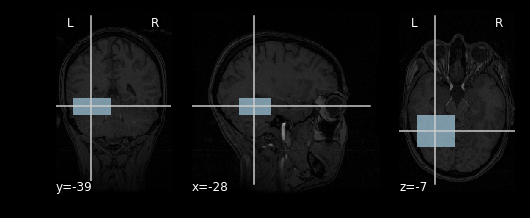

In [14]:
# Visualizing the mask, in relation to the anatomical
plot_roi(imgBox, bg_img=imgAnat, cmap='Paired')

Now let's load the behavioral data.

In [15]:
###### LOADING BEHAVIORAL DATA
# loading the behavior data into a dataframe
targetData = pd.read_csv(tableTarget, sep=' ')
# stimulus types
targetNames = sorted(targetData.labels.unique())
# Creating numerical labels
targetData['labelInd'] = 0
for i,iCat in enumerate(targetNames):
    targetData.loc[targetData.labels==iCat, 'labelInd'] = i

And mask for time points for faces and houses only.

In [16]:
###### MASKING FOR SELECTED STIMS
targetNames = ['face', 'house']  # the stims of interest
stimMask = targetData.labels.isin(targetNames)  # indices for the stim of interest
y = np.array(targetData.labelInd)[stimMask]  # labels
X = index_img(imgfMRIDetrend, stimMask)   # selecting only the selected time points
                                         # from the fMRI time series, creating a
                                         # new image object


## Searchlight

Now, we will perform a cross-validation in conjunction with searchlight. In order to do so, we need to specify which observations (or time points) are used as training and testing data for each iteration of the cross-validation. To do so, we use the cross-validation (train-test splitting) object **`KFold`** from **`sklearn.model_selection`**. We perform a 5-fold cross-validation (thus `n_splits=5`).

In [17]:
###### SEARCHLIGHT WITH SVM
cv = KFold(n_splits=5)   # cross-validation splitting object

Then specifying the searchlight object. Interestingly we need to specify two masks: one for specifying brain voxels, and the other for specifying voxels where searchlight is performed.

In [18]:
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(imgMask,  # mask image object
                          process_mask_img=imgBox,  # voxel block image object
                          radius=5.6,  # radius is 5.6
                          cv=cv)
searchlight.fit(X, y)

SearchLight(cv=KFold(n_splits=5, random_state=None, shuffle=False),
            estimator='svc',
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f48a1ec89b0>,
            n_jobs=1,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f48a1ec8898>,
            radius=5.6, scoring=None, verbose=0)

Apparently **`radius=5.6`** (in mm) has been determined to be the optimal radius for this particular data set.

We haven't talked about the classification method used in this searchlight. By default, `SearchLight` uses the **`SVC`** from `sklearn.svm`. The default parameters (that we care about) are **`C=1.0`** and **`kernel='linear'`**.


## Visualization

The attribute of interest, for the searchlight object is **`.scores_`**. This is a vector of precision score, from each searchlight neighborhood, summarizing how accurate the classifier performance was. We can visualize it by transforming back to the brain space.

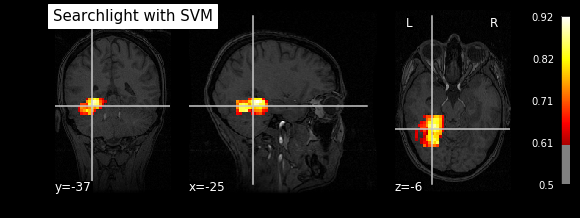

In [19]:
###### VISUALIZING THE SEARCHLIGHT RESULTS
# mean fMRI image (i.e., fMRI image without time dimension)
mean_fmri = mean_img(imgfMRI)
# searchlight score image object
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(searchlight_img, bg_img=imgAnat,
         title="Searchlight with SVM", colorbar=True,
         vmin=.50, cmap='hot', threshold=.6, black_bg=True)

As you can see, some voxels are very informative, with scores close to 90%.